<a href="https://colab.research.google.com/github/VictorNigretto/ProjetLong/blob/main/Segmentation_non_supervis%C3%A9e_%22facile%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce colab, je vais essayer de réaliser une segmentation non supervisée, pour segmenter le sol, des pierres, des arbres et des lacs sur des images de forêts

In [1]:
import os
import shutil
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, optimizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, Input
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import EfficientNetB7, ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.callbacks import LearningRateScheduler
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import load_img
from PIL import Image
from keras.utils import to_categorical 
import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

Récupération d'une image de test

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 100_0001_0116.JPG to 100_0001_0116.JPG


On vérifie la taille de l'image et on l'affiche

In [3]:
import random
from keras.preprocessing.image import load_img

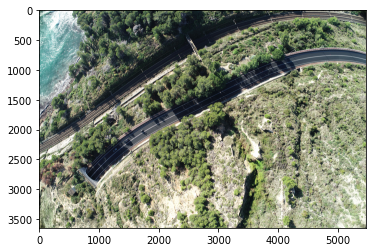

Image shape :  (3648, 5472, 3)


In [4]:
image = load_img('100_0001_0116.JPG')
plt.imshow(image)
plt.show()
print("Image shape : ", np.shape(image))
image = np.array(image)

In [5]:
from skimage.transform import rescale, resize, downscale_local_mean

image = rescale(image, 0.10, multichannel=True, anti_aliasing=True)

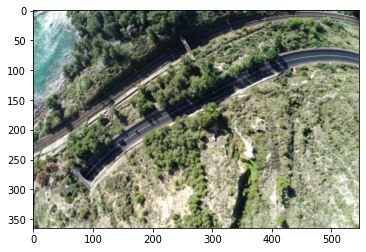

image reshaped shape :  (365, 547, 3)


In [6]:
plt.imshow(image)
plt.show()
print("image reshaped shape : ", np.shape(image))

Nous effectuons une segmentation avec l'algorithme quickshift et affichons l'image avec ses superpixels

Quickshift number of segments: 376


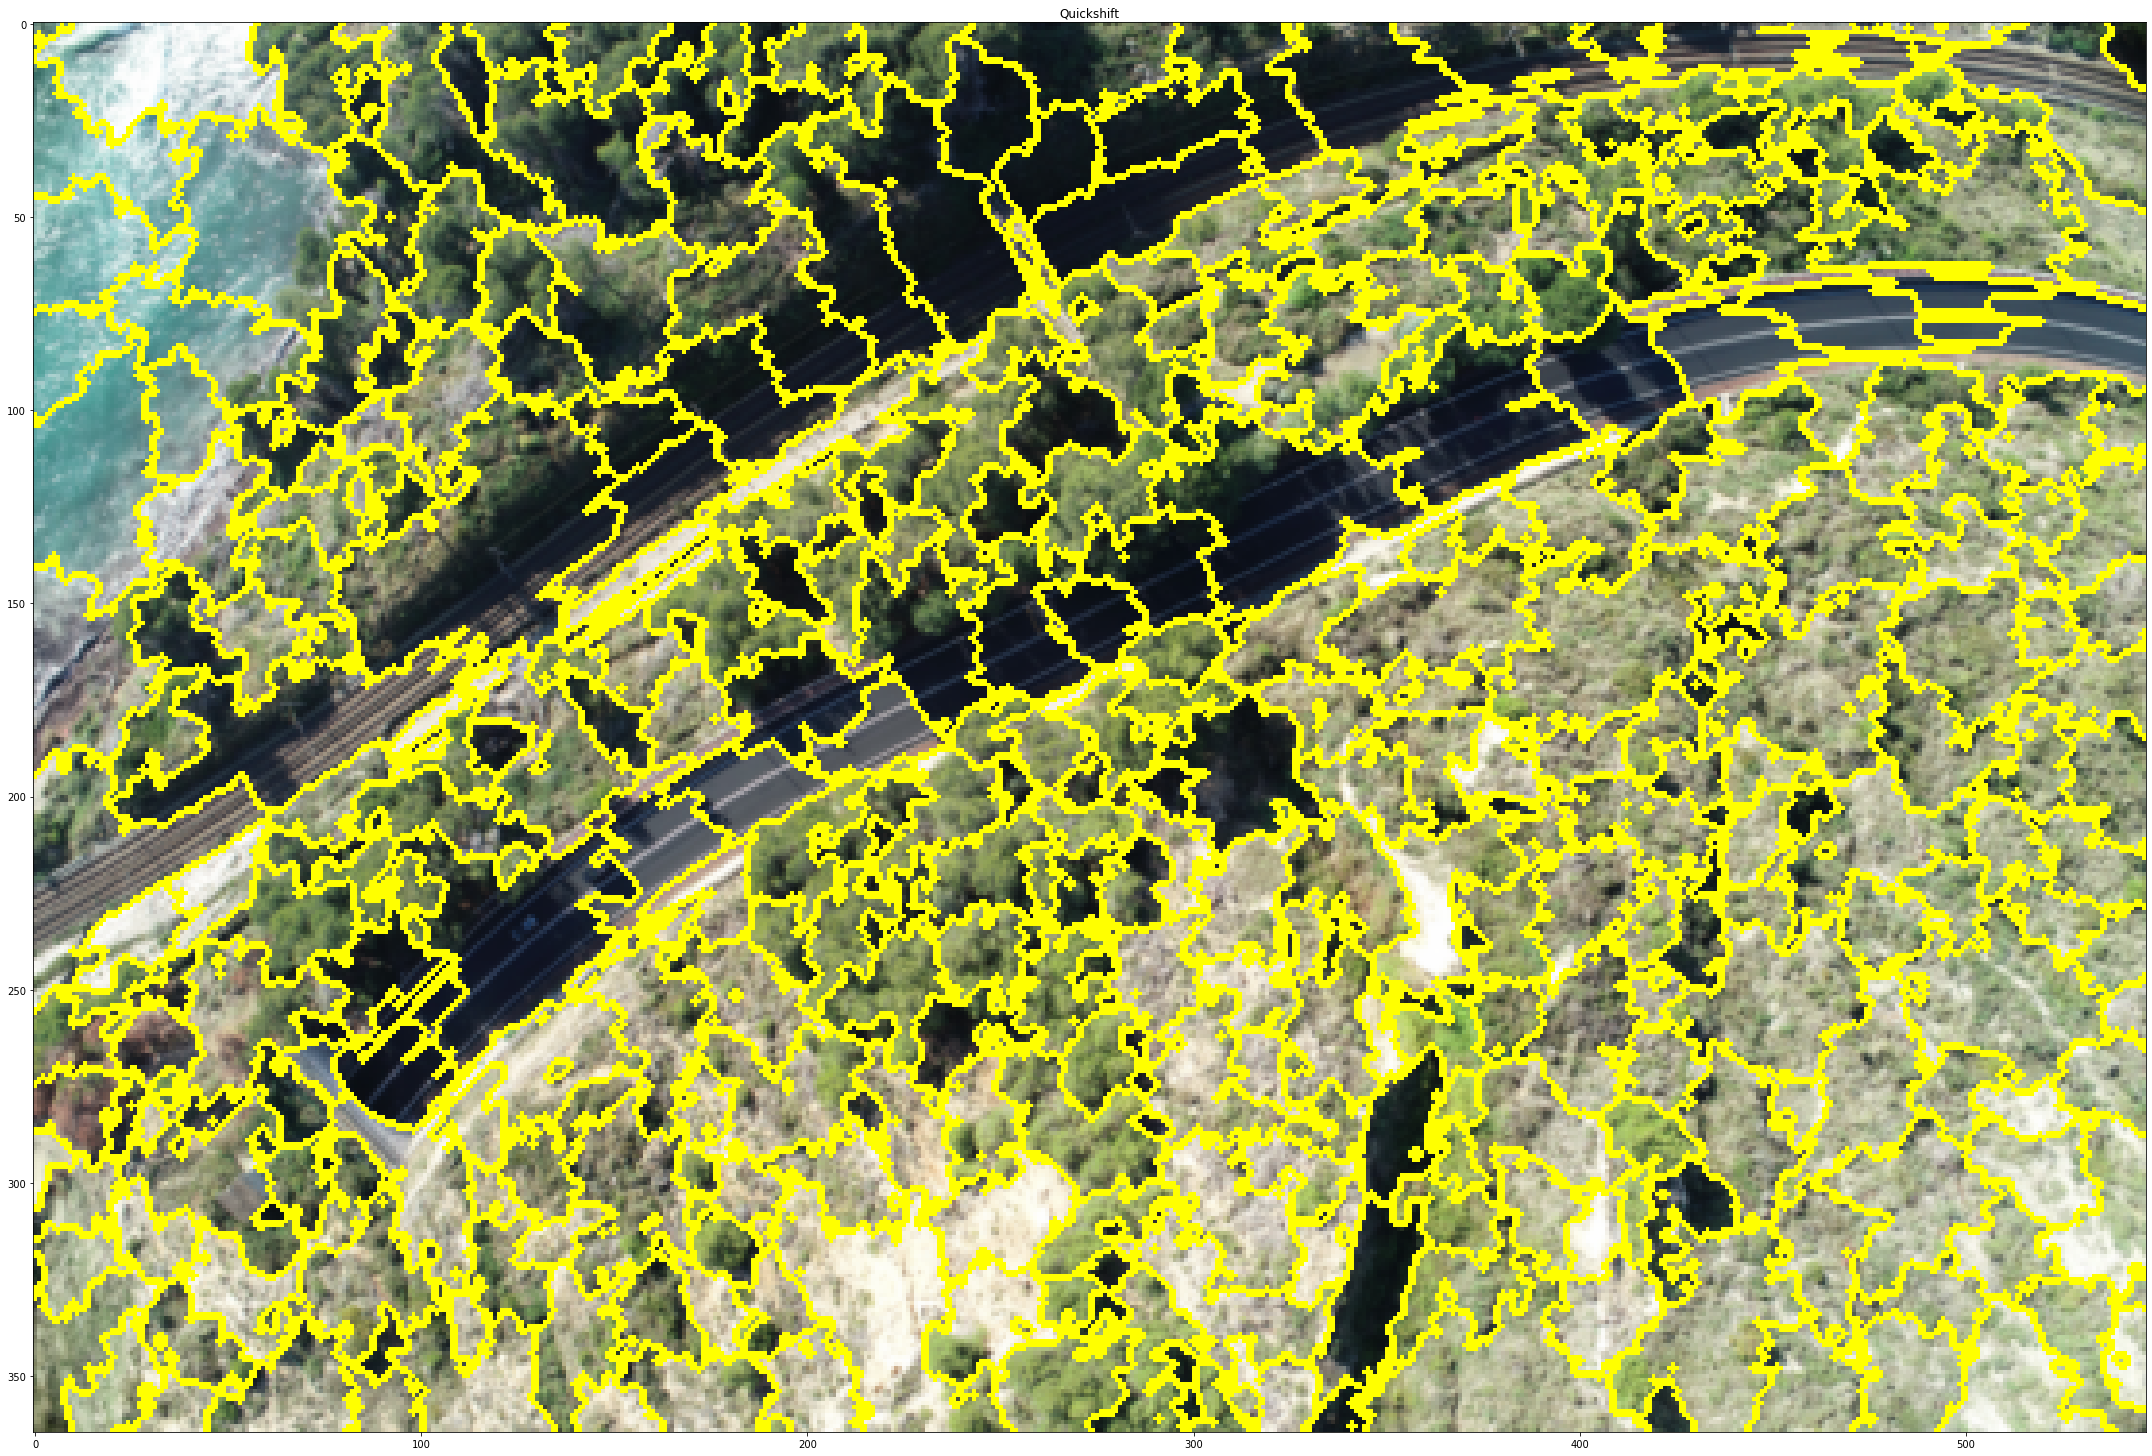

In [7]:
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.color import rgb2gray

img = img_as_float(image)
segments_quick = quickshift(img, kernel_size=3, max_dist=20, ratio=0.5)

#gradient = sobel(rgb2gray(img))
#segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
#print(f"Compact Watershed number of segments: {len(np.unique(segments_watershed))}")
fig, ax = plt.subplots(1, 1, figsize=(30, 30), sharex=True, sharey=True)


ax.imshow(mark_boundaries(img, segments_quick))
ax.set_title('Quickshift')

#ax[1].imshow(mark_boundaries(img, segments_watershed))
#ax[1].set_title('Compact watershed')


plt.tight_layout()
plt.show()

Ensuite, nous calculons la couleur moyenne de chaque pixel.

In [46]:
def mean_color(image=image, segments=segments_quick):
  img_reshaped = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
  print("img reshaped shape", np.shape(img_reshaped))

  segments_reshaped = np.reshape(segments, -1)    
  print("segment reshaped shape", np.shape(segments_reshaped))

  unique_segments = np.unique(segments_reshaped)
  print("unique segment shape", np.shape(unique_segments))
  img_temp = np.zeros(img_reshaped.shape)

  for i in unique_segments:
    loc=np.where(segments_reshaped==i)[0]
    #print(loc)
    means=np.mean(img_reshaped[loc, :], axis=0)
    img_temp[loc, :] = means

  return np.reshape(img_temp, [image.shape[0], image.shape[1], image.shape[2]])


In [47]:
mean_img = mean_color(image, segments_quick)

img reshaped shape (199655, 3)
segment reshaped shape (199655,)
unique segment shape (376,)


On obtient une nouvelle image de couleur moyenne

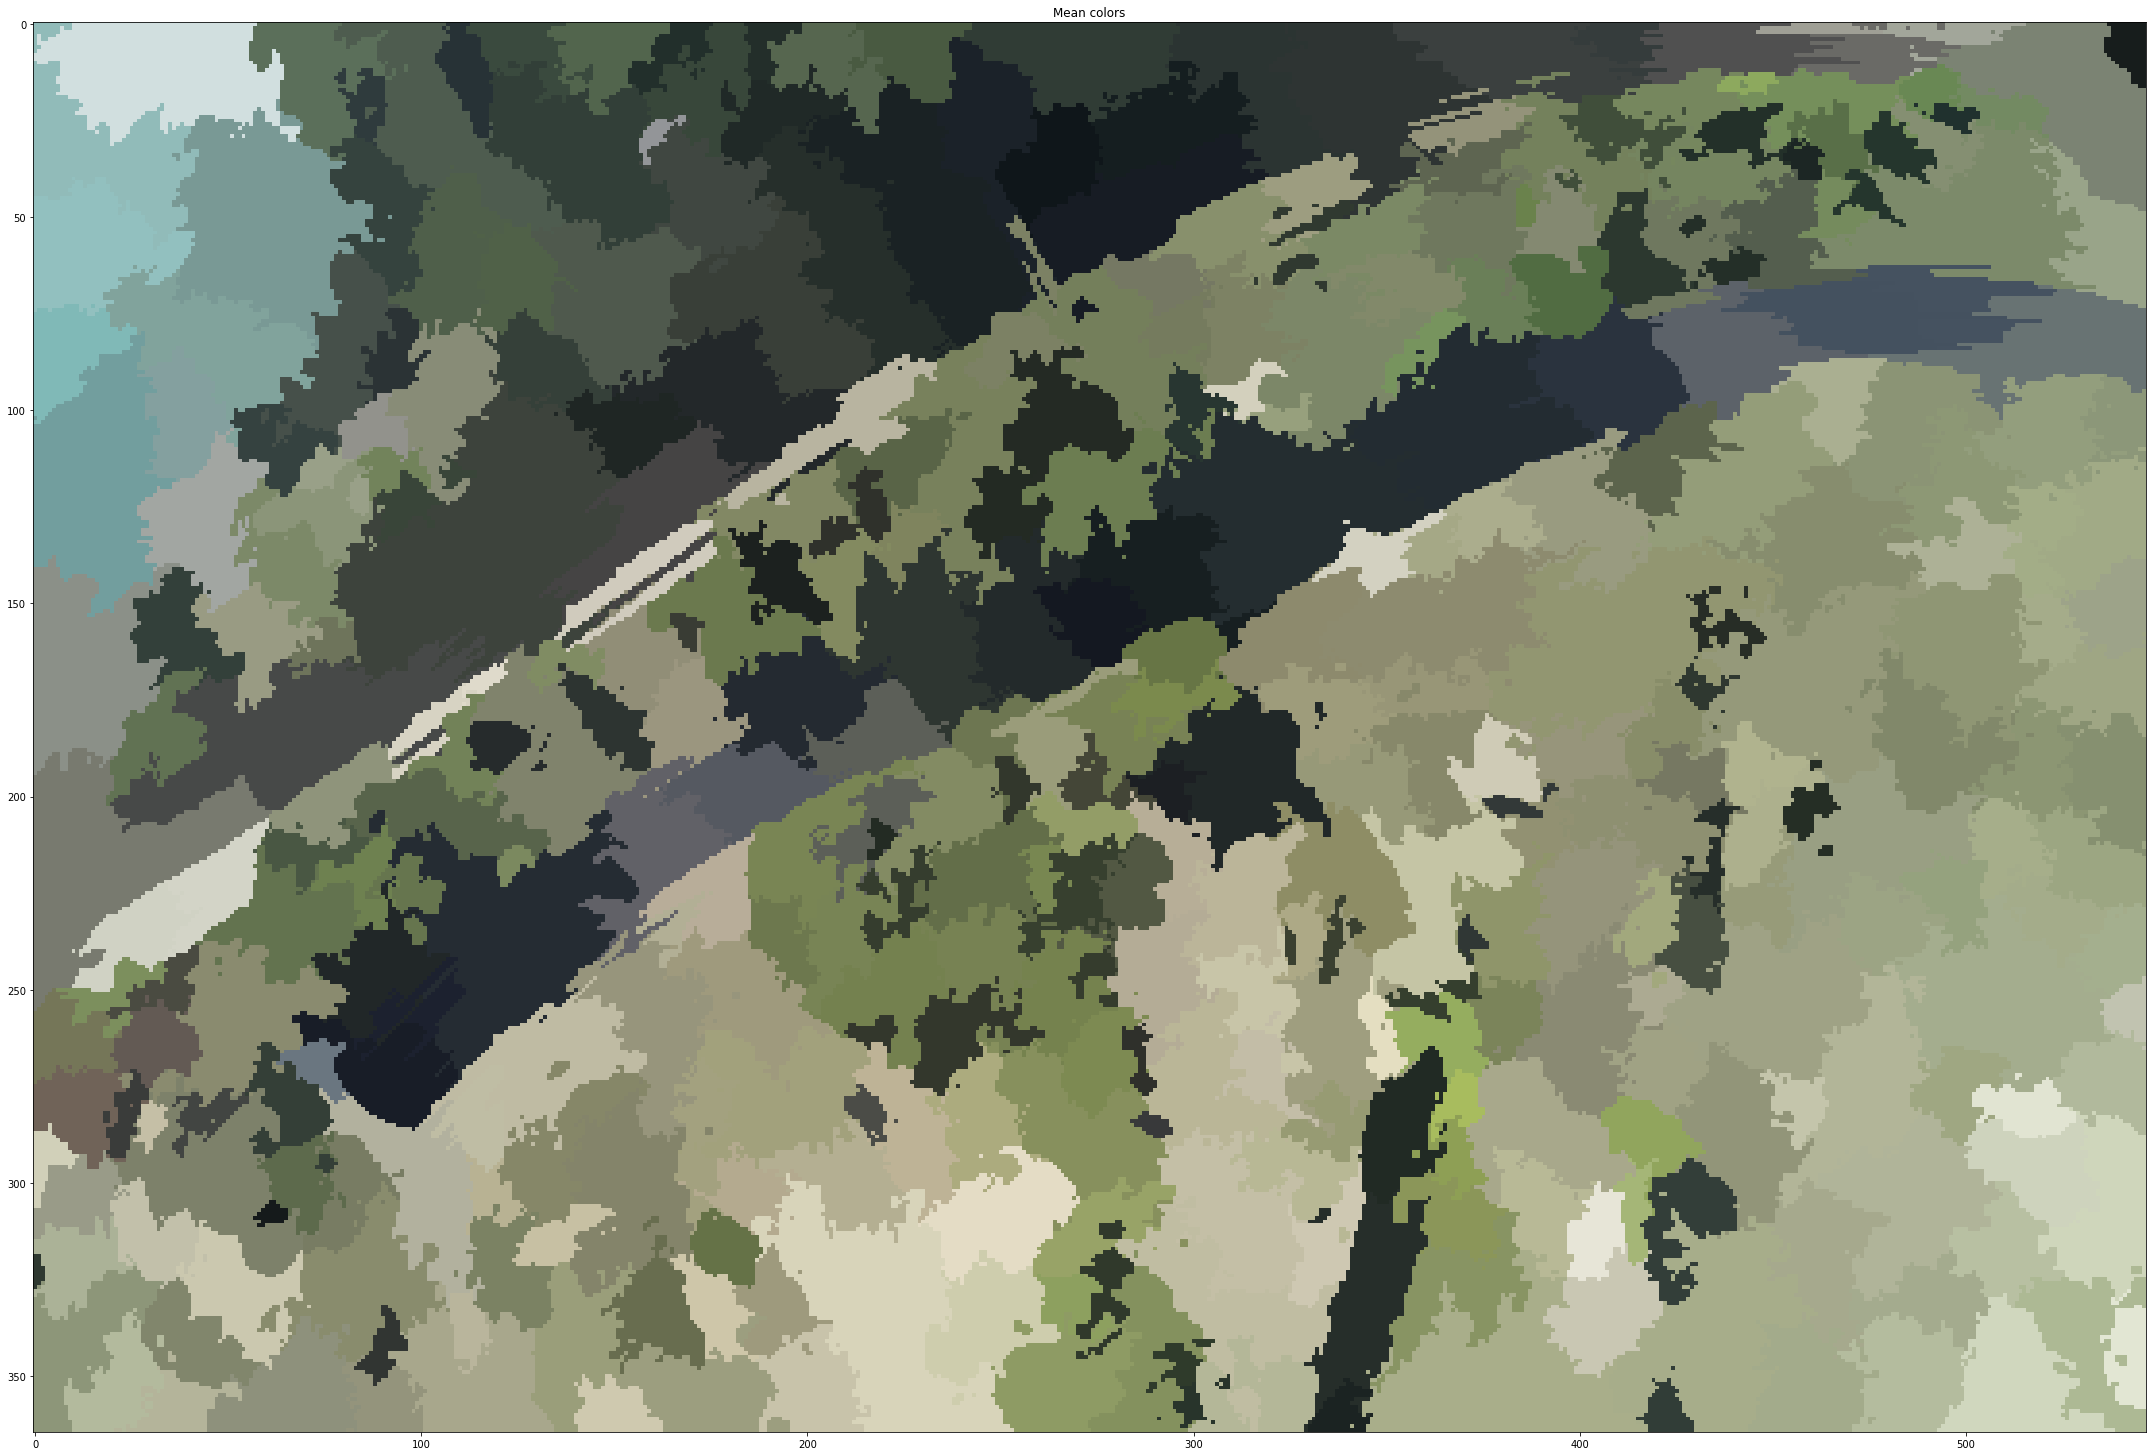

In [10]:

fig, ax = plt.subplots(1, 1, figsize=(30, 30), sharex=True, sharey=True)

#ax[0].imshow(image)
#ax[0].set_title('Original resized image')

ax.imshow(mean_img)
ax.set_title('Mean colors')

plt.tight_layout()
plt.show()


Nous essayons d'augmenter le contraste de l'image pour faciliter la labélisation

In [11]:
from skimage.color import rgb2hsv, hsv2rgb
print(np.shape(image))
image_hsv = rgb2hsv(image)

print(np.shape(image_hsv))
#print(image_hsv)

image_hsv[:,:,1] = 1
img_contrasted = hsv2rgb(image_hsv)


(365, 547, 3)
(365, 547, 3)


img reshaped shape (199655, 3)
segment reshaped shape (199655,)
unique segment shape (376,)


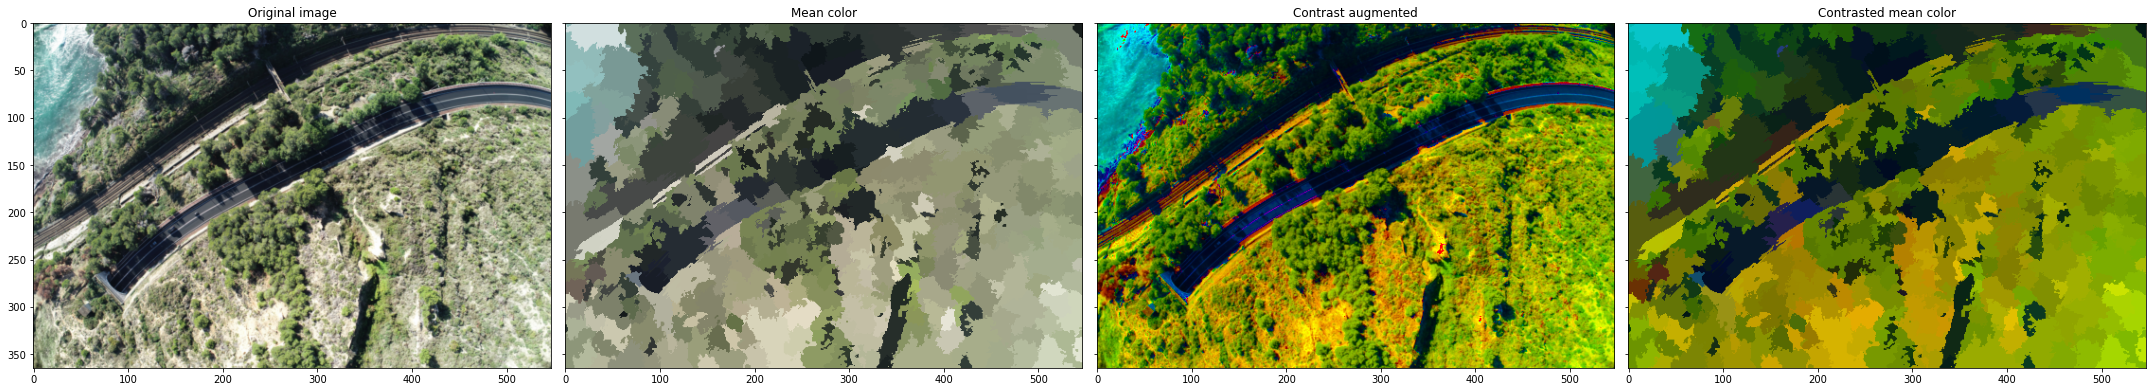

In [12]:
img_contrasted_mean = mean_color(img_contrasted, segments_quick)

fig, ax = plt.subplots(1, 4, figsize=(30, 30), sharex=True, sharey=True)

#ax[0].imshow(image)
#ax[0].set_title('Original resized image')

ax[0].imshow(image)
ax[0].set_title('Original image')

ax[1].imshow(mean_img)
ax[1].set_title('Mean color')

ax[2].imshow(img_contrasted)
ax[2].set_title('Contrast augmented')

ax[3].imshow(img_contrasted_mean)
ax[3].set_title('Contrasted mean color')
plt.tight_layout()
plt.show()

Le résultat n'est pas incroyable. Nous allons tracer une carte de couleur de l'image segmentée et transformer cela en un problème de clusturing.

On tente de visualiser le nuage de point pour voir le résultat

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

def cloud_repartition_rgb_img(img=mean_img, segments=segments_quick):
  img_reshaped = img.reshape((img.shape[0]*img.shape[1], img.shape[2]))
  print("img reshaped shape :", np.shape(img_reshaped))
  segments_reshaped = np.reshape(segments, -1)    
  print("segment reshaped shape", np.shape(segments_reshaped))

  unique_segments = np.unique(segments_reshaped)
  print("unique segment shape", np.shape(unique_segments))
  img_unique_pixels = np.zeros((unique_segments.shape[0], 3))
  print("img unique pixel shape :", np.shape(img_unique_pixels))

  for i in unique_segments:
    loc=np.where(segments_reshaped==i)[0][0]
    #print(loc)
    img_unique_pixels[i, :] = img_reshaped[loc, :]

  img_unique_pixels = 255*img_unique_pixels
  print(np.shape(img_unique_pixels))
  # Création de la figure
  fig = plt.figure()
  ax3D = fig.add_subplot(111, projection='3d')

  # Tracé
  p3d = ax3D.scatter(img_unique_pixels[:, 0], img_unique_pixels[:, 1], img_unique_pixels[:, 2], zdir='z', s=20, c='red', depthshade=True) 


  # Axes
  ax3D.set_xlabel('X Label')
  ax3D.set_ylabel('Y Label')
  ax3D.set_zlabel('Z Label')



In [14]:
def cloud_repartition_hsv_img(img=mean_img, segments=segments_quick):
  img = rgb2hsv(img)
  #print(img)
  img_reshaped = img.reshape((img.shape[0]*img.shape[1], img.shape[2]))
  print("img reshaped shape :", np.shape(img_reshaped))
  segments_reshaped = np.reshape(segments, -1)    
  print("segment reshaped shape", np.shape(segments_reshaped))

  unique_segments = np.unique(segments_reshaped)
  print("unique segment shape", np.shape(unique_segments))
  img_unique_pixels = np.zeros((unique_segments.shape[0], 3))
  print("img unique pixel shape :", np.shape(img_unique_pixels))

  for i in unique_segments:
    loc=np.where(segments_reshaped==i)[0][0]
    #print(loc)
    img_unique_pixels[i, :] = img_reshaped[loc, :]

  # Création de la figure
  fig = plt.figure()
  ax3D = fig.add_subplot(111, projection='3d')

  # Tracé
  p3d = ax3D.scatter(img_unique_pixels[:, 0], img_unique_pixels[:, 1], img_unique_pixels[:, 2], zdir='z', s=20, c='red', depthshade=True) 


  # Axes
  ax3D.set_xlabel('X Label')
  ax3D.set_ylabel('Y Label')
  ax3D.set_zlabel('Z Label')

img reshaped shape : (199655, 3)
segment reshaped shape (199655,)
unique segment shape (376,)
img unique pixel shape : (376, 3)
(376, 3)
img reshaped shape : (199655, 3)
segment reshaped shape (199655,)
unique segment shape (376,)
img unique pixel shape : (376, 3)


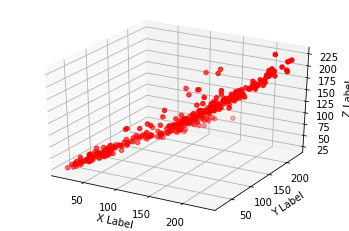

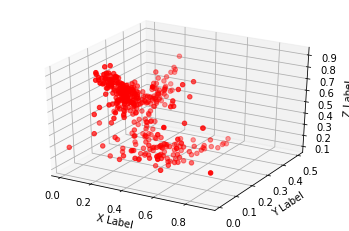

In [15]:
cloud_repartition_rgb_img()
cloud_repartition_hsv_img()

On tente ensuite à l'aveugle d'appliquer DBScan sur chacun de ces 2 nuages, pour voir si ça arrive à clusturiser correctement.

Définition de img_unique_pixels_rgb

In [17]:
img_reshaped = mean_img.reshape((mean_img.shape[0]*mean_img.shape[1], mean_img.shape[2]))
segments_reshaped = np.reshape(segments_quick, -1)    
unique_segments = np.unique(segments_reshaped)
img_unique_pixels_rgb = np.zeros((unique_segments.shape[0], 3))
print("img unique pixel shape :", np.shape(img_unique_pixels_rgb))

for i in unique_segments:
  loc=np.where(segments_reshaped==i)[0][0]
  #print(loc)
  img_unique_pixels_rgb[i, :] = img_reshaped[loc, :]

img unique pixel shape : (376, 3)


In [19]:
mean_img_hsv = rgb2hsv(mean_img)
img_reshaped = mean_img.reshape((mean_img_hsv.shape[0]*mean_img_hsv.shape[1], mean_img_hsv.shape[2]))
segments_reshaped = np.reshape(segments_quick, -1)    
unique_segments = np.unique(segments_reshaped)
img_unique_pixels_hsv = np.zeros((unique_segments.shape[0], 3))
print("img unique pixel shape :", np.shape(img_unique_pixels_hsv))

for i in unique_segments:
  loc=np.where(segments_reshaped==i)[0][0]
  #print(loc)
  img_unique_pixels_hsv[i, :] = img_reshaped[loc, :]

img unique pixel shape : (376, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


number of class for rgb : (3,)
number of unclassified for rgb : (1, 0)
number of class for hsv : (3,)
number of unclassified for hsv : (1, 0)
img reshaped shape (199655, 3)
unique segment shape (376,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


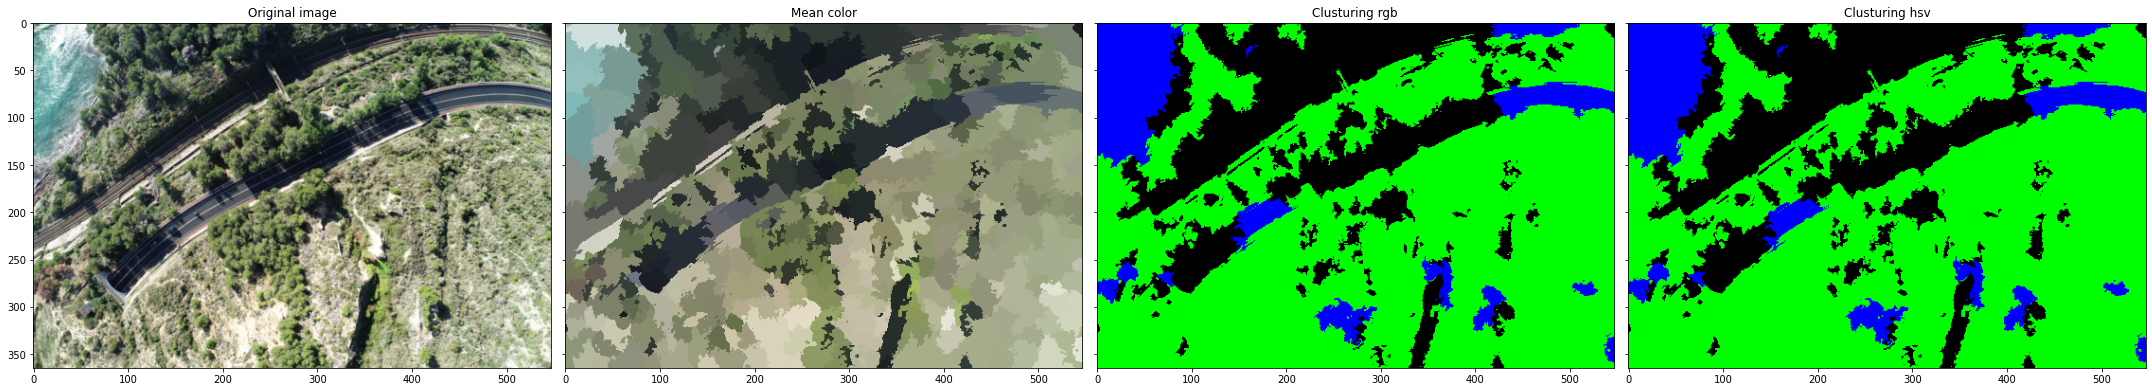

In [52]:
from sklearn.cluster import DBSCAN


dbs_rgb = DBSCAN(eps=0.05, min_samples=10)
dbs_rgb.fit(img_unique_pixels_rgb)
#print(dbs_rgb.labels_)

dbs_hsv = DBSCAN(eps=0.05, min_samples=10)
dbs_hsv.fit(img_unique_pixels_hsv)
#print(dbs_hsv.labels_)

print("number of class for rgb :", np.unique(dbs_rgb.labels_).shape)
print("number of unclassified for rgb :", np.shape(np.where(dbs_rgb == -1)))

print("number of class for hsv :", np.unique(dbs_hsv.labels_).shape)
print("number of unclassified for hsv :", np.shape(np.where(dbs_hsv ==-1)))

img_reshaped = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))

print("img reshaped shape", np.shape(img_reshaped))

segments_reshaped = np.reshape(segments_quick, -1)    
#print("segment reshaped shape", np.shape(segments_reshaped))

unique_segments = np.unique(segments_reshaped)
print("unique segment shape", np.shape(unique_segments))
img_temp_rgb = np.zeros(img_reshaped.shape)
img_temp_hsv = np.zeros(img_reshaped.shape)

for i in unique_segments:
  loc=np.where(segments_reshaped==i)[0]
  if (dbs_rgb.labels_[i] == -1) :
    img_temp_rgb[loc, :] = [0, 0, 255]
  if (dbs_hsv.labels_[i] == -1) :
    img_temp_hsv[loc, :] = [0, 0, 255]

  if (dbs_rgb.labels_[i] == 0):
    img_temp_rgb[loc, :] = [0, 0, 0]
  if (dbs_hsv.labels_[i] == 0):
    img_temp_hsv[loc, :] = [0, 0, 0]

  if (dbs_rgb.labels_[i] == 1):
    img_temp_rgb[loc, :] = [0, 255, 0]
  if (dbs_hsv.labels_[i] == 1):
    img_temp_hsv[loc, :] = [0, 255, 0]

  if (dbs_rgb.labels_[i] == 2):
    img_temp_rgb[loc, :] = [255, 255, 0]
  if (dbs_hsv.labels_[i] == 2):
    img_temp_hsv[loc, :] = [255, 255, 0]

  elif (dbs_rgb.labels_[i] > 2):
    img_temp_rgb[loc, :] = np.random.randn(1, 3)*255
  elif (dbs_hsv.labels_[i] > 2):
    img_temp_hsv[loc, :] = np.random.rand(1, 3)*255


img_temp_rgb = np.reshape(img_temp_rgb, [image.shape[0], image.shape[1], image.shape[2]])
img_temp_hsv = np.reshape(img_temp_hsv, [image.shape[0], image.shape[1], image.shape[2]])

print("img temp rgb shape :", np.shape(img_temp_rgb))
print("img temp hsv shape :", np.shape(img_temp_hsv))

# plot img
fig, ax = plt.subplots(1, 4, figsize=(30, 30), sharex=True, sharey=True)

ax[0].imshow(image)
ax[0].set_title('Original image')

ax[1].imshow(mean_img)
ax[1].set_title('Mean color')

ax[2].imshow(img_temp_rgb)
ax[2].set_title('Clusturing rgb')

ax[3].imshow(img_temp_hsv)
ax[3].set_title("Clusturing hsv")


plt.tight_layout()
plt.show()